In [60]:
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import json

In [109]:
eth = yf.Ticker("ETH-USD")
end_date = datetime.now().strftime('%Y-%m-%d')
df = eth.history(period='max',end=end_date, interval='1m')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-09-17 00:00:00+00:00,2295.295654,2295.295654,2295.295654,2295.295654,0,0.0,0.0
2024-09-17 00:01:00+00:00,2294.682373,2294.682373,2294.682373,2294.682373,0,0.0,0.0
2024-09-17 00:02:00+00:00,2294.441406,2294.441406,2294.441406,2294.441406,0,0.0,0.0
2024-09-17 00:03:00+00:00,2295.823486,2295.823486,2295.823486,2295.823486,0,0.0,0.0
2024-09-17 00:04:00+00:00,2296.619385,2296.619385,2296.619385,2296.619385,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-09-23 23:54:00+00:00,2647.475586,2647.475586,2647.475586,2647.475586,0,0.0,0.0
2024-09-23 23:55:00+00:00,2647.793945,2647.793945,2647.793945,2647.793945,0,0.0,0.0
2024-09-23 23:56:00+00:00,2648.343018,2648.343018,2648.343018,2648.343018,86016,0.0,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9489 entries, 2024-09-16 00:00:00+00:00 to 2024-09-22 23:58:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9489 non-null   float64
 1   High          9489 non-null   float64
 2   Low           9489 non-null   float64
 3   Close         9489 non-null   float64
 4   Volume        9489 non-null   int64  
 5   Dividends     9489 non-null   float64
 6   Stock Splits  9489 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 593.1 KB


In [4]:
df["Dividends"].value_counts()

Dividends
0.0    9489
Name: count, dtype: int64

In [5]:
df["Stock Splits"].value_counts()

Stock Splits
0.0    9489
Name: count, dtype: int64

In [110]:
df = df.drop(columns=["Dividends","Stock Splits","High","Low","Open"])
df = df.rename(columns={"Close":"Value"})
with open('info.json', 'r') as openfile:
    info = json.load(openfile)
info["ETH-USD"]["max"] = df["Value"].max()
info["ETH-USD"]["min"] = df["Value"].min()
with open('info.json', 'w') as outfile:
    json.dump(info, outfile)
df["Value"] = (df["Value"] - df["Value"].min()) / (df["Value"].max() - df["Value"].min())
df

,Value,Volume
Datetime,,
2024-09-17 00:00:00+00:00,0.071187,0
2024-09-17 00:01:00+00:00,0.069779,0
2024-09-17 00:02:00+00:00,0.069226,0
2024-09-17 00:03:00+00:00,0.072399,0
2024-09-17 00:04:00+00:00,0.074226,0
...,...,...
2024-09-23 23:54:00+00:00,0.879708,0
2024-09-23 23:55:00+00:00,0.880439,0
2024-09-23 23:56:00+00:00,0.881700,86016


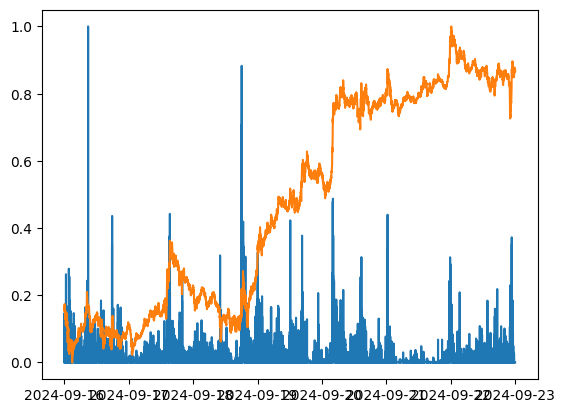

In [7]:
plt.plot(df.index,df["Volume"])
plt.plot(df.index,df["Value"])
plt.show()

In [8]:

values = df["Value"].values.reshape(-1,1)
X_train = []
y_train = []
for i in range(60, len(df)-3000):
    X_train.append(values[i-60:i, 0])
    y_train.append(values[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(len(df)-2940, len(df)):
    X_test.append(values[i-60:i, 0])
    y_test.append(values[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [11]:
model = Sequential()
model.add(LSTM(units=55,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.15))
model.add(LSTM(units=55,return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(units=55,return_sequences=True))
model.add(Dropout(0.15))
model.add(LSTM(units=55))
model.add(Dropout(0.15))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_absolute_error')
model.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100


c:\Users\Inteli\Desktop\PondMod7\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


201/201 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.0596
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 0.0248
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - loss: 0.0258
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - loss: 0.0213
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - loss: 0.0200
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - loss: 0.0198
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - loss: 0.0189
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.0183
Epoch 9/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - loss: 0.0185
Epoch 10/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - loss: 0.0164
Epoch 11/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - loss: 0.0166
Epoch 12/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - loss: 0.0166
Epoch 13/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - loss: 0.0160
Epoch 14/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - loss: 0.0161
Epoch 15/100
201

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step


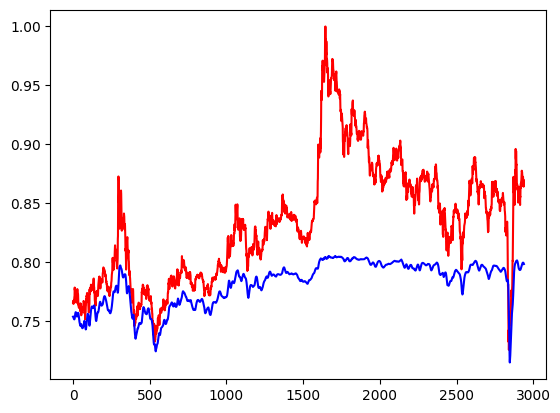

In [12]:
y_pred = model.predict(X_test)
plt.plot(y_test, color = 'red', label = 'Real Value')
plt.plot(y_pred, color = 'blue', label = 'Predicted Value')
plt.show()

In [13]:
model.save("modelo_eth.h5")

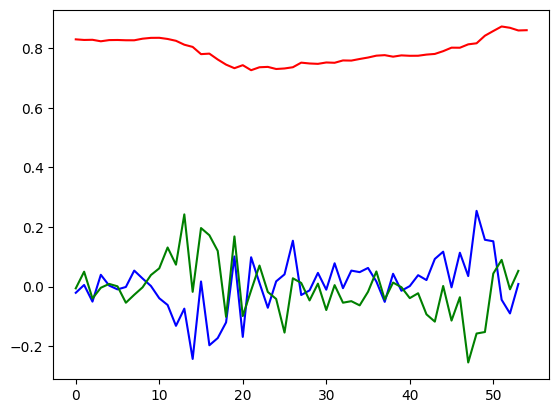

In [112]:
deltaL = []
deltaN = []
for i in range(2821,2875):
    deltaL.append((y_test[i] - y_test[i-1])*10)
    deltaN.append((y_test[i] - y_test[i+1])*10)
plt.plot(y_test[2820:2875], color = 'red', label = 'Real Value')
plt.plot(deltaL, color = 'blue', label = 'Delta Last')
plt.plot(deltaN, color = 'green', label = 'Delta Next')
plt.show()

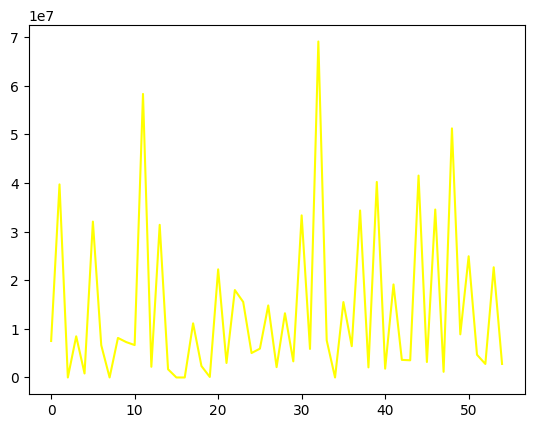

In [113]:
plt.plot(df["Volume"].values[8820:8875], color = 'yellow', label = 'Volume')
plt.show()

In [118]:
a = df[8820:8875]
a.reindex()
a[a["Volume"] < 10000000].shape

(34, 2)

In [138]:
import requests
import pandas as pd

x = requests.get("http://127.0.0.1:8000/hist_btc")
print(x.text)
# d = pd.DataFrame.from_dict(x.text, orient='index')
# d


{"20/09/2024 00:00:00":{"Value":62958.390625},"20/09/2024 00:01:00":{"Value":62998.4140625},"20/09/2024 00:02:00":{"Value":63020.19921875},"20/09/2024 00:03:00":{"Value":62993.94140625},"20/09/2024 00:05:00":{"Value":62938.94921875},"20/09/2024 00:06:00":{"Value":62940.0},"20/09/2024 00:07:00":{"Value":62906.42578125},"20/09/2024 00:08:00":{"Value":62886.34375},"20/09/2024 00:09:00":{"Value":62870.9140625},"20/09/2024 00:10:00":{"Value":62900.0859375},"20/09/2024 00:11:00":{"Value":62871.16796875},"20/09/2024 00:12:00":{"Value":62895.28125},"20/09/2024 00:13:00":{"Value":62843.5625},"20/09/2024 00:14:00":{"Value":62862.04296875},"20/09/2024 00:15:00":{"Value":62896.3671875},"20/09/2024 00:17:00":{"Value":62870.9375},"20/09/2024 00:18:00":{"Value":62852.9921875},"20/09/2024 00:19:00":{"Value":62857.375},"20/09/2024 00:20:00":{"Value":62837.70703125},"20/09/2024 00:21:00":{"Value":62860.65234375},"20/09/2024 00:22:00":{"Value":62848.4765625},"20/09/2024 00:23:00":{"Value":62857.953125},"